Fitting 5 folds for each of 108 candidates, totalling 540 fits

Grid Search Completed in 143.48 seconds.

Best parameters found:
{'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__learning_rate_init': 0.001, 'mlp__max_iter': 700, 'mlp__solver': 'lbfgs'}
Cross-validation F1: 0.7839 ± 0.1329


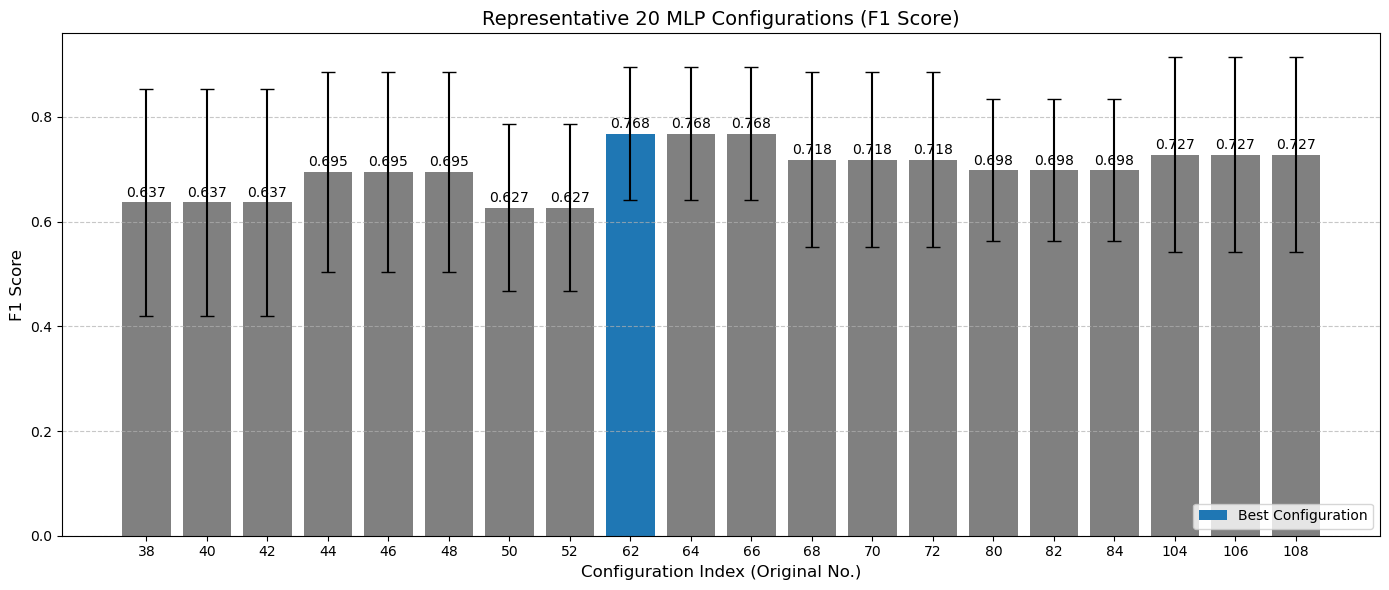


Best Configuration Summary:
Config: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__learning_rate_init': 0.001, 'mlp__max_iter': 700, 'mlp__solver': 'lbfgs'}
F1 Score: 0.7676


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# 加载数据
df = pd.read_excel('D:/YANER/MII/LB2/Data_Set_(A+B).xlsx')
df['is_type_4'] = (df['Type'] == 4).astype(int)

# 特征和标签
features = ['N1','N2','N3','ω1','ω2','ω3','I1','I2','I3','gx','gy','gz','ax','ay','az']
X_train = df[features]
y_train = df['is_type_4']

# 定义 Pipeline
pipeline = Pipeline([
    ('mlp', MLPClassifier(early_stopping=True, random_state=42))
])

# 参数网格
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100, 50), (150, 100, 50)],
    'mlp__activation': ['relu', 'tanh', 'logistic'],
    'mlp__solver': ['adam', 'lbfgs'],
    'mlp__alpha': [1e-4, 1e-3],  # 正则项
    'mlp__learning_rate_init': [0.001, 0.01, 0.1],  # 初始学习率（对 'sgd'/'adam' 有效）
    'mlp__max_iter': [700]
}

# 创建 GridSearchCV 对象
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={'f1': make_scorer(f1_score, average='binary'), 
             'accuracy': make_scorer(accuracy_score)},
    refit='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# 模型训练 + 时间记录
start = time.time()
grid.fit(X_train, y_train)
end = time.time()
print(f"\nGrid Search Completed in {(end - start):.2f} seconds.")

# 输出最佳参数
print("\nBest parameters found:")
print(grid.best_params_)

# 保存最优模型（已经是训练好的）
best_model = grid.best_estimator_

# 交叉验证分数
best_model = grid.best_estimator_
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1')
print(f"Cross-validation F1: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")



# 获取所有配置的 F1 分数及索引
f1_scores = grid.cv_results_['mean_test_f1']
std_scores = grid.cv_results_['std_test_f1']

# 转换成 DataFrame，方便筛选
result_df = pd.DataFrame({
    'index': range(len(f1_scores)),
    'f1_score': f1_scores,
    'std': std_scores
})

# 取 10 个最高分
top_20 = result_df.nlargest(20, 'f1_score')

# 合并代表性配置
selected_configs = pd.concat([top_20]).sort_values('index').reset_index(drop=True)

# 找到最佳模型索引
best_index = np.argmax(f1_scores)

# 设置颜色
colors = ['gray'] * len(selected_configs)
for i, idx in enumerate(selected_configs['index']):
    if idx == best_index:
        colors[i] = '#1f77b4'

# 配置标签
config_labels = [str(idx+1) for idx in selected_configs['index']]

# 绘制柱状图
plt.figure(figsize=(14, 6))
bars = plt.bar(config_labels, selected_configs['f1_score'], color=colors, yerr=selected_configs['std'], capsize=5)

# 标注分数
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.3f}", ha='center', va='bottom')

# 图表信息
plt.title("Representative 20 MLP Configurations (F1 Score)", fontsize=14)
plt.xlabel("Configuration Index (Original No.)", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(handles=[bars[colors.index('#1f77b4')]], labels=['Best Configuration'], loc='lower right')
plt.tight_layout()
plt.show()


# 输出最佳配置信息
print("\nBest Configuration Summary:")
print(f"Config: {grid.best_params_}")
print(f"F1 Score: {f1_scores[best_index]:.4f}")


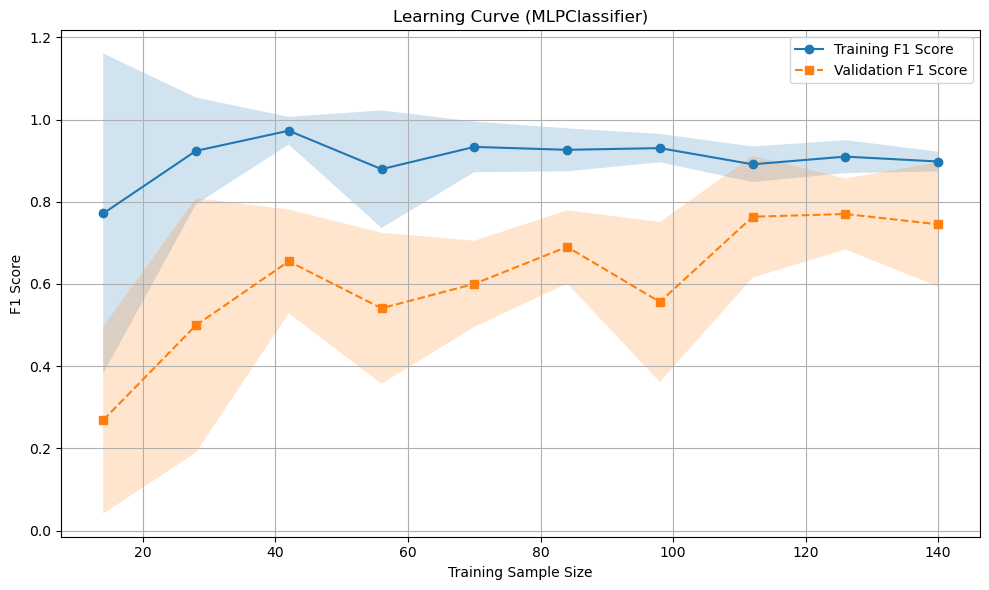

In [26]:
from sklearn.model_selection import learning_curve

# 使用最佳模型绘制学习曲线
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# 学习曲线图
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training F1 Score', marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2)
plt.plot(train_sizes, val_scores_mean, label='Validation F1 Score', marker='s', linestyle='--')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2)

plt.title('Learning Curve (MLPClassifier)')
plt.xlabel('Training Sample Size')
plt.ylabel('F1 Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


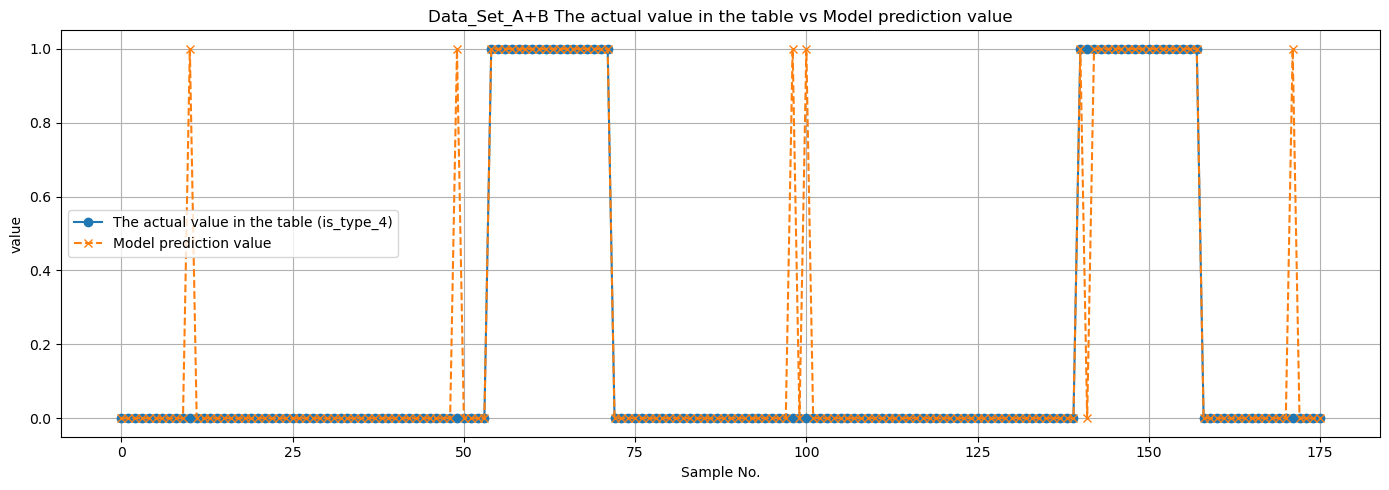

In [27]:
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import numpy as np


# 使用最优模型直接预测
y_pred = best_model.predict(X_train)  # 直接使用

# 假设 X, y 已定义并预处理
model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='tanh',
    solver='lbfgs',
    alpha=0.001,
    learning_rate_init=0.001,
    max_iter=700,
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_train)

N = len(y_train)

plt.figure(figsize=(14, 5))
plt.plot(np.arange(N), y_train[:N], label='The actual value in the table (is_type_4)', marker='o')
plt.plot(np.arange(N), y_pred[:N], label='Model prediction value', marker='x', linestyle='--')
plt.title('Data_Set_A+B The actual value in the table vs Model prediction value')
plt.xlabel('Sample No.')
plt.ylabel('value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 基于排序数据的网络训练

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Grid Search Completed in 140.71 seconds.

Best parameters found:
{'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (150, 100, 50), 'mlp__learning_rate_init': 0.001, 'mlp__max_iter': 700, 'mlp__solver': 'lbfgs'}
Cross-validation F1: 0.6740 ± 0.1779


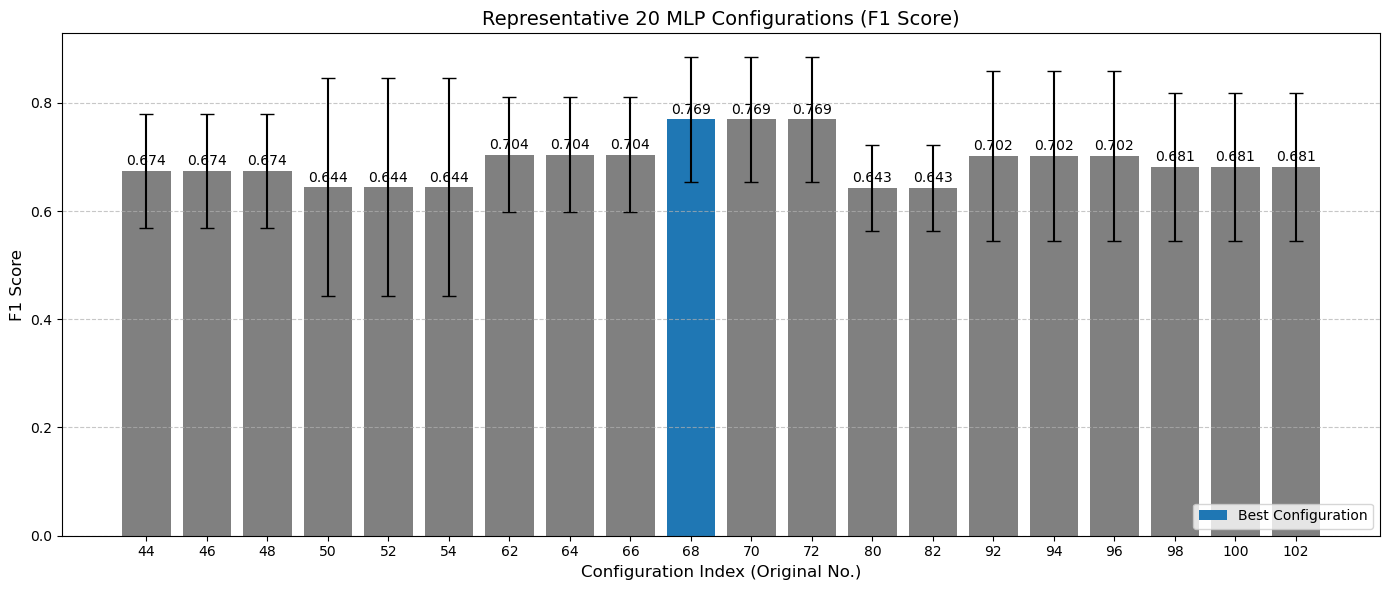


Best Configuration Summary:
Config: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (150, 100, 50), 'mlp__learning_rate_init': 0.001, 'mlp__max_iter': 700, 'mlp__solver': 'lbfgs'}
F1 Score: 0.7692


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# 加载数据
df = pd.read_excel('D:/YANER/MII/LB2/Data_Set_Sort.xlsx')
df['is_type_4'] = (df['Type'] == 4).astype(int)

# 特征和标签
features = ['N1','N2','N3','ω1','ω2','ω3','I1','I2','I3','gx','gy','gz','ax','ay','az']
X_train = df[features]
y_train = df['is_type_4']

# 定义 Pipeline
pipeline = Pipeline([
    ('mlp', MLPClassifier(early_stopping=True, random_state=42))
])

# 参数网格
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100, 50), (150, 100, 50)],
    'mlp__activation': ['relu', 'tanh', 'logistic'],
    'mlp__solver': ['adam', 'lbfgs'],
    'mlp__alpha': [1e-4, 1e-3],  # 正则项
    'mlp__learning_rate_init': [0.001, 0.01, 0.1],  # 初始学习率（对 'sgd'/'adam' 有效）
    'mlp__max_iter': [700]
}

# 创建 GridSearchCV 对象
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={'f1': make_scorer(f1_score, average='binary'), 
             'accuracy': make_scorer(accuracy_score)},
    refit='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# 模型训练 + 时间记录
start = time.time()
grid.fit(X_train, y_train)
end = time.time()
print(f"\nGrid Search Completed in {(end - start):.2f} seconds.")

# 输出最佳参数
print("\nBest parameters found:")
print(grid.best_params_)

# 保存最优模型（已经是训练好的）
best_model1 = grid.best_estimator_

# 交叉验证分数
best_model1 = grid.best_estimator_
cv_scores = cross_val_score(best_model1, X_train, y_train, cv=5, scoring='f1')
print(f"Cross-validation F1: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")



# 获取所有配置的 F1 分数及索引
f1_scores = grid.cv_results_['mean_test_f1']
std_scores = grid.cv_results_['std_test_f1']

# 转换成 DataFrame，方便筛选
result_df = pd.DataFrame({
    'index': range(len(f1_scores)),
    'f1_score': f1_scores,
    'std': std_scores
})

# 取 10 个最高分
top_20 = result_df.nlargest(20, 'f1_score')

# 合并代表性配置
selected_configs = pd.concat([top_20]).sort_values('index').reset_index(drop=True)

# 找到最佳模型索引
best_index = np.argmax(f1_scores)

# 设置颜色
colors = ['gray'] * len(selected_configs)
for i, idx in enumerate(selected_configs['index']):
    if idx == best_index:
        colors[i] = '#1f77b4'

# 配置标签
config_labels = [str(idx+1) for idx in selected_configs['index']]

# 绘制柱状图
plt.figure(figsize=(14, 6))
bars = plt.bar(config_labels, selected_configs['f1_score'], color=colors, yerr=selected_configs['std'], capsize=5)

# 标注分数
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.3f}", ha='center', va='bottom')

# 图表信息
plt.title("Representative 20 MLP Configurations (F1 Score)", fontsize=14)
plt.xlabel("Configuration Index (Original No.)", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(handles=[bars[colors.index('#1f77b4')]], labels=['Best Configuration'], loc='lower right')
plt.tight_layout()
plt.show()


# 输出最佳配置信息
print("\nBest Configuration Summary:")
print(f"Config: {grid.best_params_}")
print(f"F1 Score: {f1_scores[best_index]:.4f}")


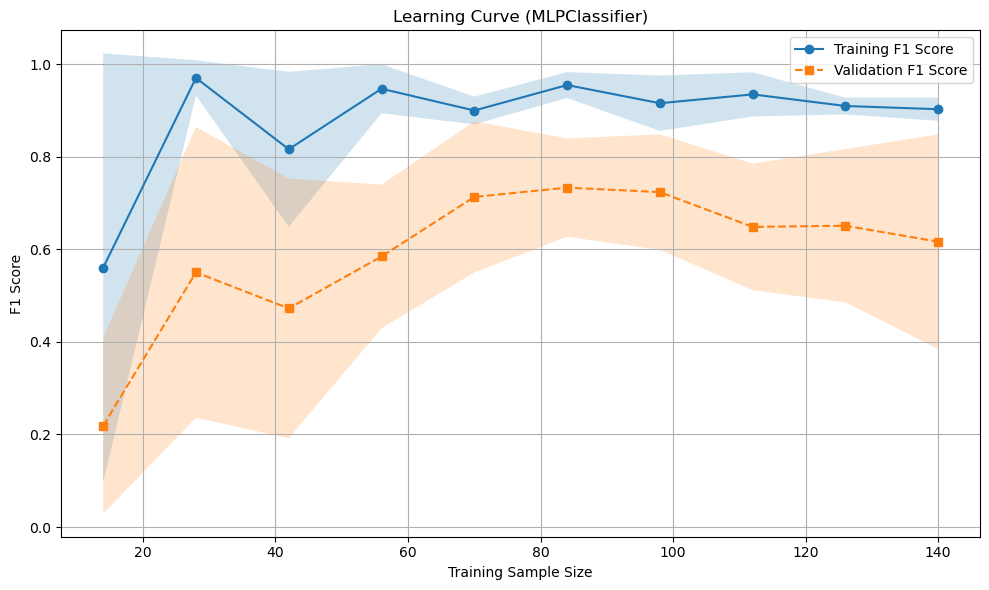

In [29]:
from sklearn.model_selection import learning_curve

# 使用最佳模型绘制学习曲线
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# 学习曲线图
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training F1 Score', marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2)
plt.plot(train_sizes, val_scores_mean, label='Validation F1 Score', marker='s', linestyle='--')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2)

plt.title('Learning Curve (MLPClassifier)')
plt.xlabel('Training Sample Size')
plt.ylabel('F1 Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


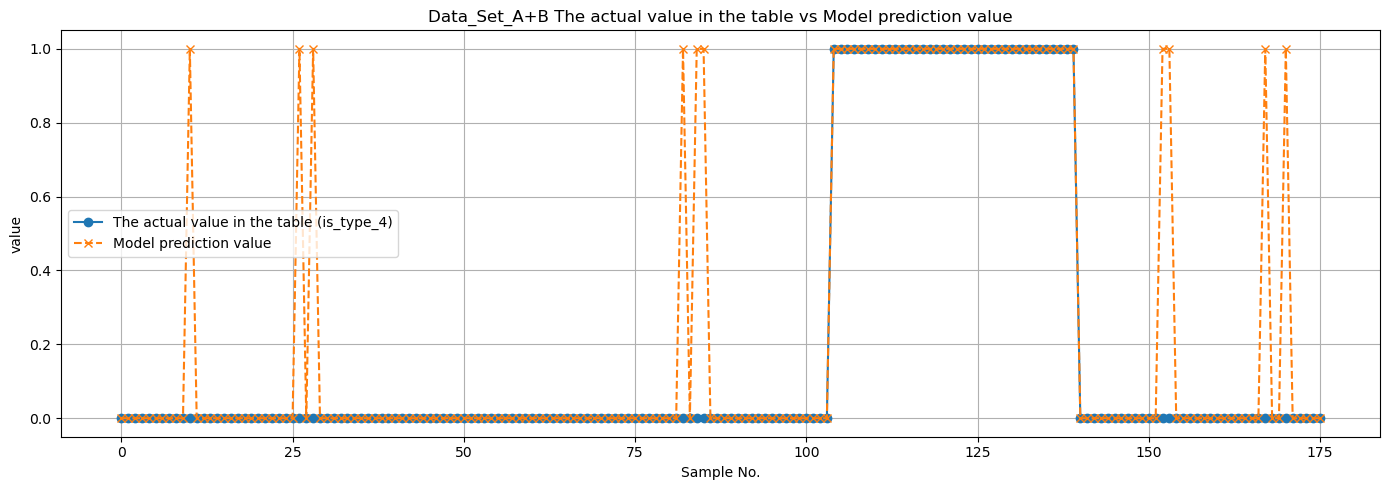

In [30]:
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import numpy as np


# 使用最优模型直接预测
y_pred = best_model.predict(X_train)  # 直接使用

# 假设 X, y 已定义并预处理
model = MLPClassifier(
    hidden_layer_sizes=(150, 100, 50),
    activation='tanh',
    solver='lbfgs',
    alpha=0.001,
    learning_rate_init=0.001,
    max_iter=700,
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_train)

N = len(y_train)

plt.figure(figsize=(14, 5))
plt.plot(np.arange(N), y_train[:N], label='The actual value in the table (is_type_4)', marker='o')
plt.plot(np.arange(N), y_pred[:N], label='Model prediction value', marker='x', linestyle='--')
plt.title('Data_Set_A+B The actual value in the table vs Model prediction value')
plt.xlabel('Sample No.')
plt.ylabel('value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 基于规范化数据的网络训练

没有排序的数据

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Grid Search Completed in 15.13 seconds.

Best parameters found:
{'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,), 'mlp__learning_rate_init': 0.001, 'mlp__max_iter': 100, 'mlp__solver': 'lbfgs'}
Cross-validation F1: 0.9579 ± 0.0345


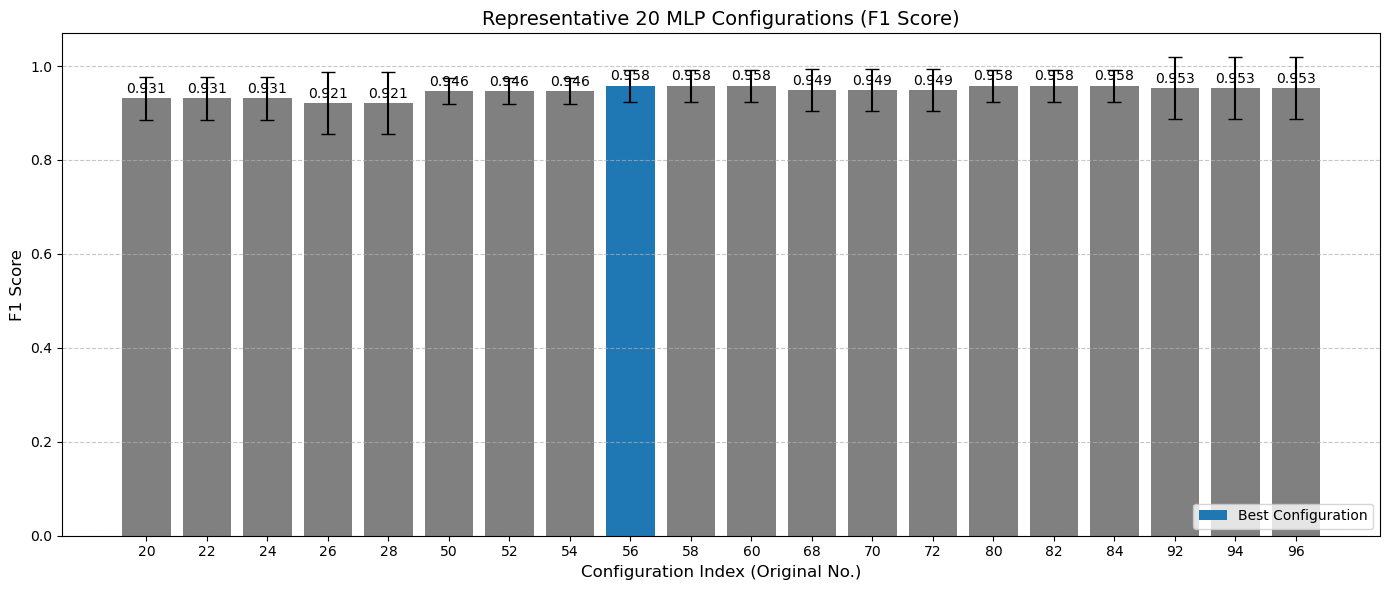


Best Configuration Summary:
Config: {'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,), 'mlp__learning_rate_init': 0.001, 'mlp__max_iter': 100, 'mlp__solver': 'lbfgs'}
F1 Score: 0.9579


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# 加载数据
df = pd.read_excel('D:/YANER/MII/LB2/Data_Set_(A+B).xlsx')
df['is_type_4'] = (df['Type'] == 4).astype(int)

# 特征和标签
features = ['N1','N2','N3','ω1','ω2','ω3','I1','I2','I3','gx','gy','gz','ax','ay','az']
X_train = df[features]
y_train = df['is_type_4']

# 定义 Pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('mlp', MLPClassifier(early_stopping=True, random_state=42)),
    ])

# 参数网格
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100, 50), (150, 100, 50)],
    'mlp__activation': ['relu', 'tanh', 'logistic'],
    'mlp__solver': ['adam', 'lbfgs'],
    'mlp__alpha': [1e-4, 1e-3],  # 正则项
    'mlp__learning_rate_init': [0.001, 0.01, 0.1],  # 初始学习率（对 'sgd'/'adam' 有效）
    'mlp__max_iter': [100]
}

# 创建 GridSearchCV 对象
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={'f1': make_scorer(f1_score, average='binary'), 
             'accuracy': make_scorer(accuracy_score)},
    refit='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# 模型训练 + 时间记录
start = time.time()
grid.fit(X_train, y_train)
end = time.time()
print(f"\nGrid Search Completed in {(end - start):.2f} seconds.")

# 输出最佳参数
print("\nBest parameters found:")
print(grid.best_params_)

# 保存最优模型（已经是训练好的）
best_model2 = grid.best_estimator_


# 交叉验证分数
best_model2 = grid.best_estimator_
cv_scores = cross_val_score(best_model2, X_train, y_train, cv=5, scoring='f1')
print(f"Cross-validation F1: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# 获取所有配置的 F1 分数及索引
f1_scores = grid.cv_results_['mean_test_f1']
std_scores = grid.cv_results_['std_test_f1']

# 转换成 DataFrame，方便筛选
result_df = pd.DataFrame({
    'index': range(len(f1_scores)),
    'f1_score': f1_scores,
    'std': std_scores
})

# 取 10 个最高分
top_20 = result_df.nlargest(20, 'f1_score')

# 合并代表性配置
selected_configs = pd.concat([top_20]).sort_values('index').reset_index(drop=True)

# 找到最佳模型索引
best_index = np.argmax(f1_scores)

# 设置颜色
colors = ['gray'] * len(selected_configs)
for i, idx in enumerate(selected_configs['index']):
    if idx == best_index:
        colors[i] = '#1f77b4'

# 配置标签
config_labels = [str(idx+1) for idx in selected_configs['index']]

# 绘制柱状图
plt.figure(figsize=(14, 6))
bars = plt.bar(config_labels, selected_configs['f1_score'], color=colors, yerr=selected_configs['std'], capsize=5)

# 标注分数
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.3f}", ha='center', va='bottom')

# 图表信息
plt.title("Representative 20 MLP Configurations (F1 Score)", fontsize=14)
plt.xlabel("Configuration Index (Original No.)", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(handles=[bars[colors.index('#1f77b4')]], labels=['Best Configuration'], loc='lower right')
plt.tight_layout()
plt.show()


# 输出最佳配置信息
print("\nBest Configuration Summary:")
print(f"Config: {grid.best_params_}")
print(f"F1 Score: {f1_scores[best_index]:.4f}")



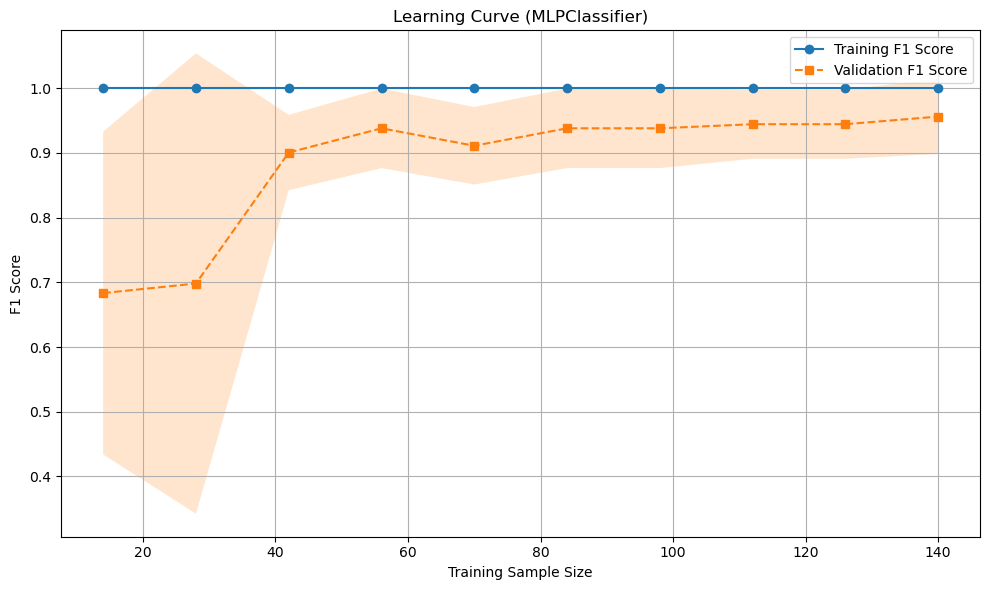

In [32]:
# 使用最优模型直接预测
y_pred = best_model2.predict(X_train)  # 直接使用

# 绘制学习曲线
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model2,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training F1 Score', marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2)
plt.plot(train_sizes, val_scores_mean, label='Validation F1 Score', marker='s', linestyle='--')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2)

plt.title('Learning Curve (MLPClassifier)')
plt.xlabel('Training Sample Size')
plt.ylabel('F1 Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


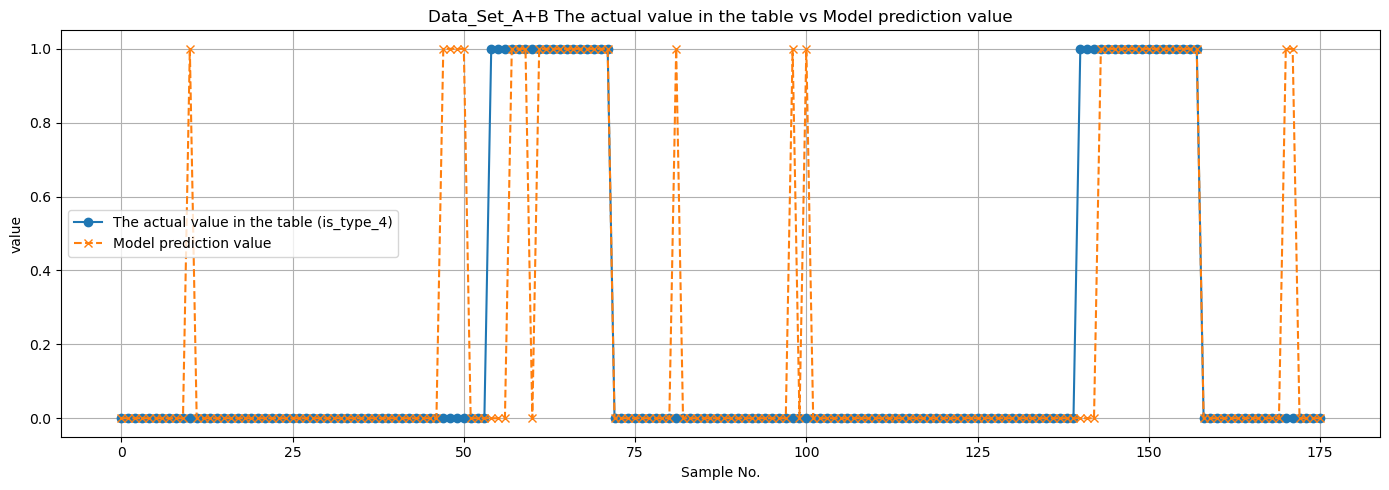

In [33]:
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import numpy as np


# 使用最优模型直接预测
y_pred = best_model.predict(X_train)  # 直接使用

# 假设 X, y 已定义并预处理
model = MLPClassifier(
    hidden_layer_sizes=(50),
    activation='tanh',
    solver='lbfgs',
    alpha=0.001,
    learning_rate_init=0.001,
    max_iter=100,
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_train)

N = len(y_train)

plt.figure(figsize=(14, 5))
plt.plot(np.arange(N), y_train[:N], label='The actual value in the table (is_type_4)', marker='o')
plt.plot(np.arange(N), y_pred[:N], label='Model prediction value', marker='x', linestyle='--')
plt.title('Data_Set_A+B The actual value in the table vs Model prediction value')
plt.xlabel('Sample No.')
plt.ylabel('value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

排序后的数据

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Grid Search Completed in 14.71 seconds.

Best parameters found:
{'mlp__activation': 'logistic', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__learning_rate_init': 0.001, 'mlp__max_iter': 700, 'mlp__solver': 'lbfgs'}
Cross-validation F1: 0.9729 ± 0.0337


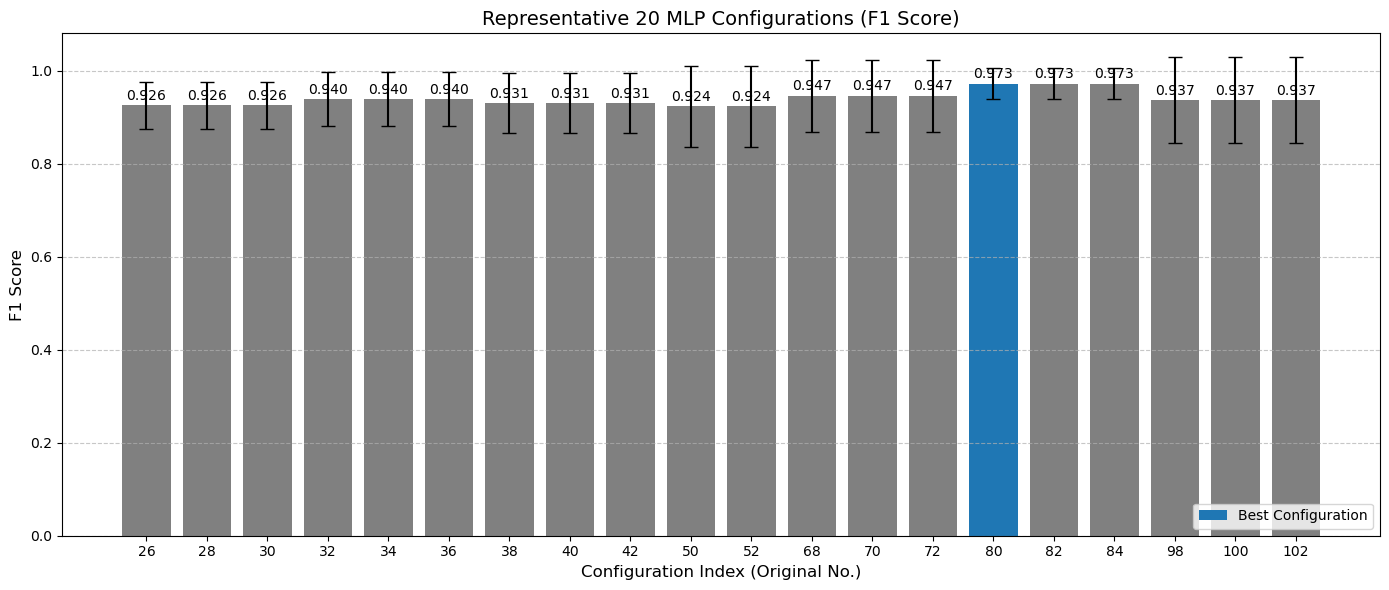


Best Configuration Summary:
Config: {'mlp__activation': 'logistic', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__learning_rate_init': 0.001, 'mlp__max_iter': 700, 'mlp__solver': 'lbfgs'}
F1 Score: 0.9729


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# 加载数据
df = pd.read_excel('D:/YANER/MII/LB2/Data_Set_Sort.xlsx')
df['is_type_4'] = (df['Type'] == 4).astype(int)

# 特征和标签
features = ['N1','N2','N3','ω1','ω2','ω3','I1','I2','I3','gx','gy','gz','ax','ay','az']
X_train = df[features]
y_train = df['is_type_4']

# 定义 Pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('mlp', MLPClassifier(early_stopping=True, random_state=42)),
    ])

# 参数网格
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100, 50), (150, 100, 50)],
    'mlp__activation': ['relu', 'tanh', 'logistic'],
    'mlp__solver': ['adam', 'lbfgs'],
    'mlp__alpha': [1e-4, 1e-3],  # 正则项
    'mlp__learning_rate_init': [0.001, 0.01, 0.1],  # 初始学习率（对 'sgd'/'adam' 有效）
    'mlp__max_iter': [700]
}

# 创建 GridSearchCV 对象
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={'f1': make_scorer(f1_score, average='binary'), 
             'accuracy': make_scorer(accuracy_score)},
    refit='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# 模型训练 + 时间记录
start = time.time()
grid.fit(X_train, y_train)
end = time.time()
print(f"\nGrid Search Completed in {(end - start):.2f} seconds.")

# 输出最佳参数
print("\nBest parameters found:")
print(grid.best_params_)

# 交叉验证分数
best_model3 = grid.best_estimator_
cv_scores = cross_val_score(best_model3, X_train, y_train, cv=5, scoring='f1')
print(f"Cross-validation F1: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# 获取所有配置的 F1 分数及索引
f1_scores = grid.cv_results_['mean_test_f1']
std_scores = grid.cv_results_['std_test_f1']

# 转换成 DataFrame，方便筛选
result_df = pd.DataFrame({
    'index': range(len(f1_scores)),
    'f1_score': f1_scores,
    'std': std_scores
})

# 取 10 个最高分
top_20 = result_df.nlargest(20, 'f1_score')

# 合并代表性配置
selected_configs = pd.concat([top_20]).sort_values('index').reset_index(drop=True)

# 找到最佳模型索引
best_index = np.argmax(f1_scores)

# 设置颜色
colors = ['gray'] * len(selected_configs)
for i, idx in enumerate(selected_configs['index']):
    if idx == best_index:
        colors[i] = '#1f77b4'

# 配置标签
config_labels = [str(idx+1) for idx in selected_configs['index']]

# 绘制柱状图
plt.figure(figsize=(14, 6))
bars = plt.bar(config_labels, selected_configs['f1_score'], color=colors, yerr=selected_configs['std'], capsize=5)

# 标注分数
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.3f}", ha='center', va='bottom')

# 图表信息
plt.title("Representative 20 MLP Configurations (F1 Score)", fontsize=14)
plt.xlabel("Configuration Index (Original No.)", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(handles=[bars[colors.index('#1f77b4')]], labels=['Best Configuration'], loc='lower right')
plt.tight_layout()
plt.show()


# 输出最佳配置信息
print("\nBest Configuration Summary:")
print(f"Config: {grid.best_params_}")
print(f"F1 Score: {f1_scores[best_index]:.4f}")



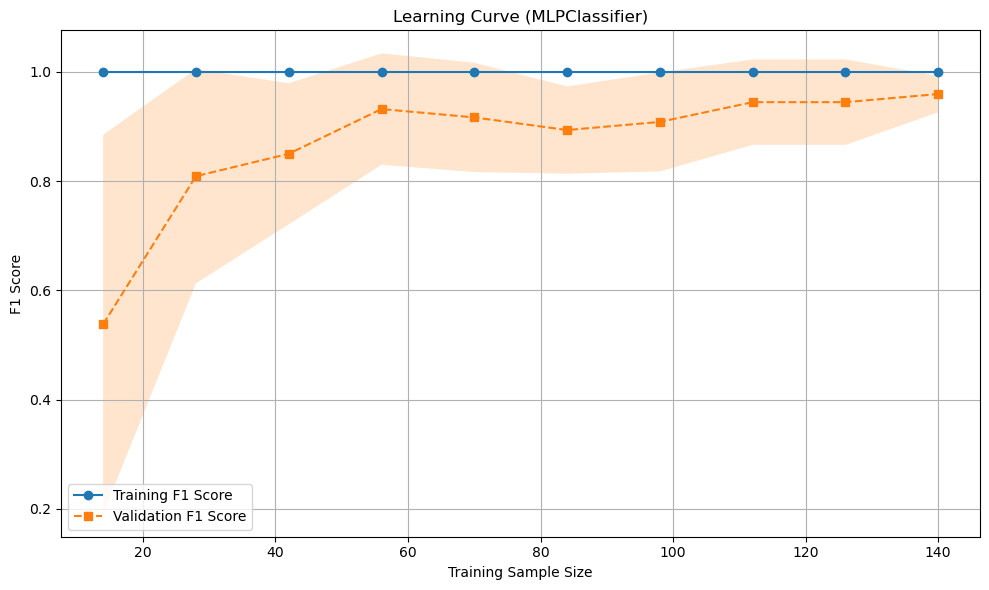

In [35]:
from sklearn.model_selection import learning_curve

# 使用最佳模型绘制学习曲线
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model3,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# 学习曲线图
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training F1 Score', marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2)
plt.plot(train_sizes, val_scores_mean, label='Validation F1 Score', marker='s', linestyle='--')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2)

plt.title('Learning Curve (MLPClassifier)')
plt.xlabel('Training Sample Size')
plt.ylabel('F1 Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


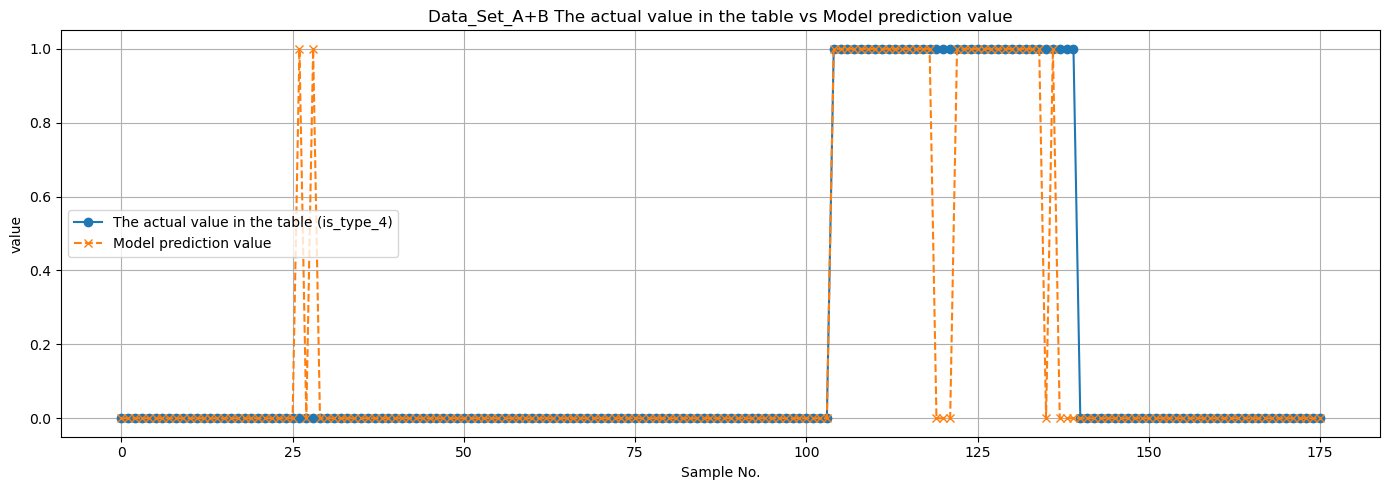

In [36]:
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import numpy as np


# 使用最优模型直接预测
y_pred = best_model.predict(X_train)  # 直接使用

# 假设 X, y 已定义并预处理
model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='logistic',
    solver='lbfgs',
    alpha=0.0001,
    learning_rate_init=0.001,
    max_iter=700,
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_train)

N = len(y_train)

plt.figure(figsize=(14, 5))
plt.plot(np.arange(N), y_train[:N], label='The actual value in the table (is_type_4)', marker='o')
plt.plot(np.arange(N), y_pred[:N], label='Model prediction value', marker='x', linestyle='--')
plt.title('Data_Set_A+B The actual value in the table vs Model prediction value')
plt.xlabel('Sample No.')
plt.ylabel('value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 基于平衡数据的网络训练

排序过进行归一化后的数据得到的f1分数最高
Config: {'mlp__activation': 'logistic', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__learning_rate_init': 0.001, 'mlp__max_iter': 100, 'mlp__solver': 'lbfgs'}
F1 Score: 0.9729
因此选用该神经网络参数进行平衡数据继续实验

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE, ADASYN

# 1. 读取数据
df = pd.read_excel("Data_Set_(A+B).xlsx")

# 2. 创建二分类标签（是否为类型4）
df['is_type_4'] = (df['Type'] == 4).astype(int)

# 3. 选择特征列
features = ['N1', 'N2', 'N3', 'ω1', 'ω2', 'ω3',
            'I1', 'I2', 'I3', 'gx', 'gy', 'gz', 'ax', 'ay', 'az']
X = df[features]
y = df['is_type_4']

# 4. 特征缩放
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 5. 划分训练集和测试集（注意 stratify 保持类别比例）
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# 6. 使用  SMOTE 仅在训练集上进行过采样
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 7. 定义神经网络模型
model = MLPClassifier(hidden_layer_sizes=(100, 50),
                      activation='logistic',
                      solver='lbfgs',
                      max_iter=100,
                      alpha=0.001,
                      learning_rate_init=0.001,
                      random_state=42)

# 8. 在训练集上训练模型
model.fit(X_train_resampled, y_train_resampled)

# 9. 在原始测试集上预测
y_pred = model.predict(X_test)

# 10. 输出评估结果
print("Test SMOTE Accuracy:", accuracy_score(y_test, y_pred))
print("Test SMOTE F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Test SMOTE Accuracy: 0.9622641509433962
Test SMOTE F1 Score: 0.9090909090909091
Confusion Matrix:
 [[41  1]
 [ 1 10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.91      0.91      0.91        11

    accuracy                           0.96        53
   macro avg       0.94      0.94      0.94        53
weighted avg       0.96      0.96      0.96        53



In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE, ADASYN

# 1. 读取数据
df = pd.read_excel("Data_Set_(A+B).xlsx")

# 2. 创建二分类标签（是否为类型4）
df['is_type_4'] = (df['Type'] == 4).astype(int)

# 3. 选择特征列
features = ['N1', 'N2', 'N3', 'ω1', 'ω2', 'ω3',
            'I1', 'I2', 'I3', 'gx', 'gy', 'gz', 'ax', 'ay', 'az']
X = df[features]
y = df['is_type_4']

# 4. 特征缩放
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 5. 划分训练集和测试集（注意 stratify 保持类别比例）
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# 6. 使用  ADASYN 仅在训练集上进行过采样
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# 7. 定义神经网络模型
model = MLPClassifier(hidden_layer_sizes=(100, 50),
                      activation='logistic',
                      solver='lbfgs',
                      max_iter=100,
                      alpha=0.001,
                      learning_rate_init=0.001,
                      random_state=42)

# 8. 在训练集上训练模型
model.fit(X_train_resampled, y_train_resampled)

# 9. 在原始测试集上预测
y_pred = model.predict(X_test)

# 10. 输出评估结果
print("Test ADASYN Accuracy:", accuracy_score(y_test, y_pred))
print("Test ADASYN F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Test ADASYN Accuracy: 0.9811320754716981
Test ADASYN F1 Score: 0.9565217391304348
Confusion Matrix:
 [[41  1]
 [ 0 11]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        42
           1       0.92      1.00      0.96        11

    accuracy                           0.98        53
   macro avg       0.96      0.99      0.97        53
weighted avg       0.98      0.98      0.98        53



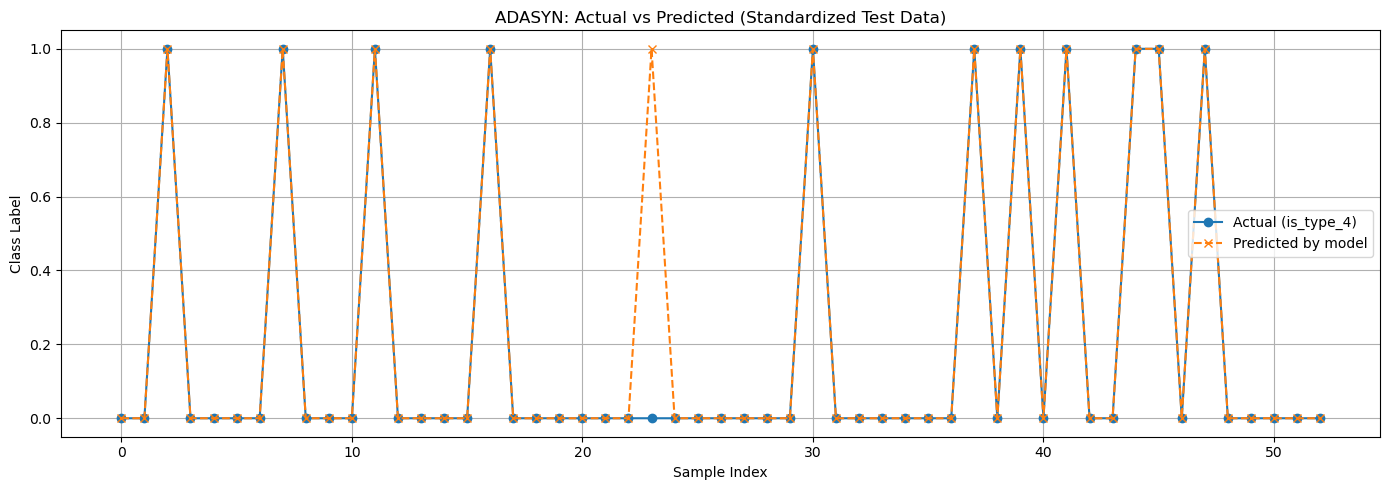

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# 如果样本数量太多可以只画前100个
N = min(len(y_test), 100)

# 创建比较图
plt.figure(figsize=(14, 5))
plt.plot(np.arange(N), y_test.to_numpy()[:N], label='Actual (is_type_4)', marker='o')
plt.plot(np.arange(N), y_pred[:N], label='Predicted by model', marker='x', linestyle='--')
plt.title('ADASYN: Actual vs Predicted (Standardized Test Data)')
plt.xlabel('Sample Index')
plt.ylabel('Class Label')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


 ADASYN训练准确率比SMOTE高拟合效果更好

# 在控制样本 C 上检查网络

In [40]:
# 加载 Data_Set_C 数据
df_c = pd.read_excel("Data_Set_C.xlsx")

# is_type_4（保持一致）
df_c['is_type_4'] = (df_c['Type'] == 4).astype(int)

X_c = df_c[features]
y_c = df_c['is_type_4']
X_c_scaled = scaler.transform(X_c)

y_c_pred = model.predict(X_c_scaled)

print("Data_Set_C accuracy:", accuracy_score(y_c, y_c_pred))
print("f1_score:", f1_score(y_c, y_c_pred))
print(confusion_matrix(y_c, y_c_pred))
print(classification_report(y_c, y_c_pred))


Data_Set_C accuracy: 0.9827586206896551
f1_score: 0.96
[[45  1]
 [ 0 12]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        46
           1       0.92      1.00      0.96        12

    accuracy                           0.98        58
   macro avg       0.96      0.99      0.97        58
weighted avg       0.98      0.98      0.98        58



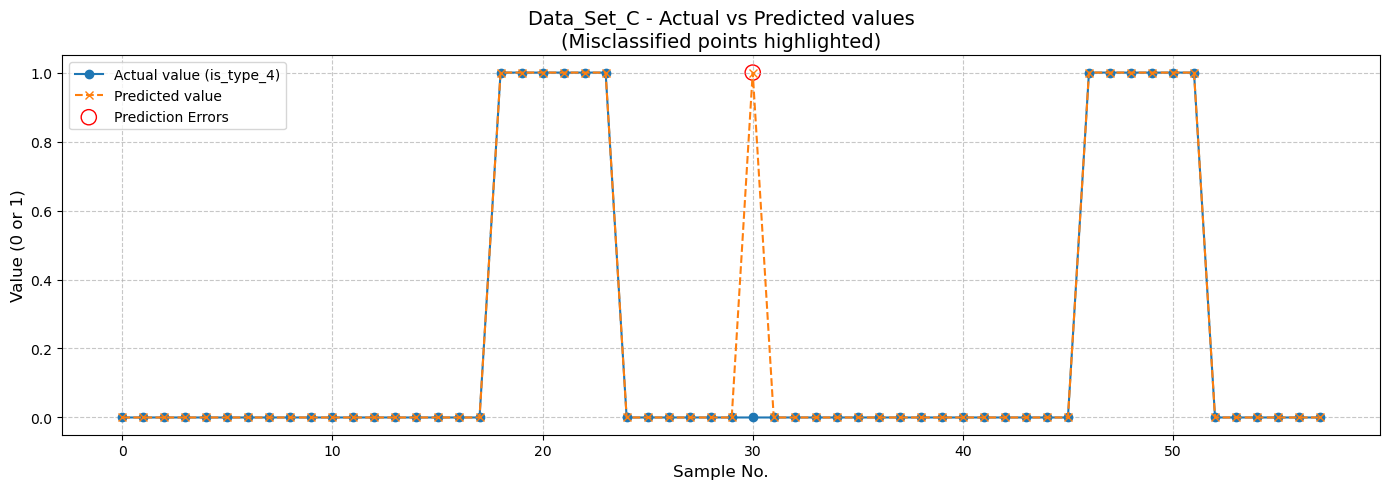

In [41]:
import matplotlib.pyplot as plt
import numpy as np

N = len(y_c)

# 计算哪些预测是错误的
errors = y_c != y_c_pred

# 创建对比图
plt.figure(figsize=(14, 5))

# 绘制实际值
plt.plot(np.arange(N), y_c[:N], label='Actual value (is_type_4)', marker='o', linestyle='-', linewidth=1.5)

# 绘制模型预测值
plt.plot(np.arange(N), y_c_pred[:N], label='Predicted value', marker='x', linestyle='--', linewidth=1.5)

# 标出预测错误的样本（红色圈）
plt.scatter(np.arange(N)[errors], y_c_pred[:N][errors], facecolors='none', edgecolors='r', s=120, label='Prediction Errors')

# 图表标题和标签
plt.title('Data_Set_C - Actual vs Predicted values\n(Misclassified points highlighted)', fontsize=14)
plt.xlabel('Sample No.', fontsize=12)
plt.ylabel('Value (0 or 1)', fontsize=12)

# 图例
plt.legend()

# 网格
plt.grid(True, linestyle='--', alpha=0.7)

# 紧凑布局
plt.tight_layout()

# 显示图表
plt.show()


通过使用 Data_Set_C 外部验证集，验证模型是否具有良好的泛化能力。 
F1 分数和准确率仍然理想，说明模型不仅能识别训练数据，还能处理新数据中的类型4的表面。